In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import scipy.stats as stats
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [8]:
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':8.,'latmax':18.,'lonmin':67.,'lonmax':72.5}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Northern Bay of Bengal':{'latmin':18.,'latmax':21.5,'lonmin':87.5,'lonmax':90.},
    'Central Bay of Bengal':{'latmin':8.5,'latmax':13.5,'lonmin':86.,'lonmax':90.}} 
BINPARAMS = {
    'pr':{'min':0,'max':None,'width':0.5},
    'bl':{'min':-0.4,'max':0.025,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
FILEDIR   = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/processed'
SAVEDIR   = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
LATRANGE  = (5.,25.)
LONRANGE  = (60.,90.)
PRTHRESH  = 0.25
CASES     = [(6,'June','red6','o'),(7,'July','green6','D'),(8,'August','blue6','s')]

In [4]:
def convert_common_units(ds):
    coeff = 9.8/(3*340)
    dims  = ['time','lat','lon']
    newds = xr.Dataset(
    data_vars=dict(
        pr=(dims,ds.pr.data),
        bl=(dims,ds.bl.data),
        cape=(dims,(coeff*ds.wb.data*ds.cape.data)),
        subsat=(dims,(coeff*ds.wl.data*ds.subsat.data))),
    coords=dict(time=ds.time.data,lat=ds.lat.data,lon=ds.lon.data))
    return newds

def apply_precipitating_mask(data,prthresh=PRTHRESH):
    return data.where(data.pr>prthresh)

def open_dataset(filename,precipitating=False,convertunits=False,prthresh=PRTHRESH,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_mfdataset(filepath)
    if precipitating==True:
        ds = apply_precipitating_mask(ds)
    if convertunits==True:
        ds = convert_common_units(ds)
    return ds

def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,month):
    return data.sel(time=data.time.dt.month==month)

In [5]:
ds = open_dataset('OBS_bl-pr_*.nc',precipitating=True,convertunits=False)

In [6]:
def get_bin_edges(da,key,binparams=BINPARAMS,prthresh=PRTHRESH):
    binmin   = binparams[key]['min']
    binmax   = binparams[key]['max']
    binwidth = binparams[key]['width']
    if key == 'pr':
        binedges = [prthresh/np.sqrt(1+binwidth)]
        prmax    = da.max().values
        while binedges[-1] < prmax:
            nextedge = binedges[-1]*(1+binwidth)
            if nextedge > prmax:
                break
            binedges.append(nextedge)
    elif key != 'pr':
        binedges = np.arange(binmin,binmax+binwidth,binwidth)
    return np.array(binedges)

def get_bin_centers(binedges):
    bincenters = (binedges[:-1]+binedges[1:])/2
    return bincenters

def calc_freq_dist(da,binedges):
    bincenters = get_bin_centers(binedges)
    flattened = da.values.flatten()
    flattened = flattened[~np.isnan(flattened)]
    hist,_    = np.histogram(flattened,bins=binedges)
    freqdist  = hist/len(flattened) if len(flattened) > 0 else np.zeros(len(bincenters))
    freqdist  = xr.DataArray(freqdist,dims=['bin'],coords={'bin':bincenters})
    return freqdist

def calc_amt_dist(da,binedges):
    bincenters = get_bin_centers(binedges)
    amtdist    = xr.DataArray(np.zeros(len(bincenters)),dims=['bin'],coords={'bin':bincenters})
    flattened = da.values.flatten()
    flattened = flattened[~np.isnan(flattened)]
    for i in range(len(bincenters)):
        amtinbin   = flattened[(flattened > binedges[i]) & (flattened <= binedges[i+1])]
        amtdist[i] = np.sum(amtinbin)
    return amtdist

def calc_mode(dist,binedges):
    bincenters = get_bin_centers(binedges)
    modeidx = dist.argmax(dim='bin')
    return bincenters[modeidx]

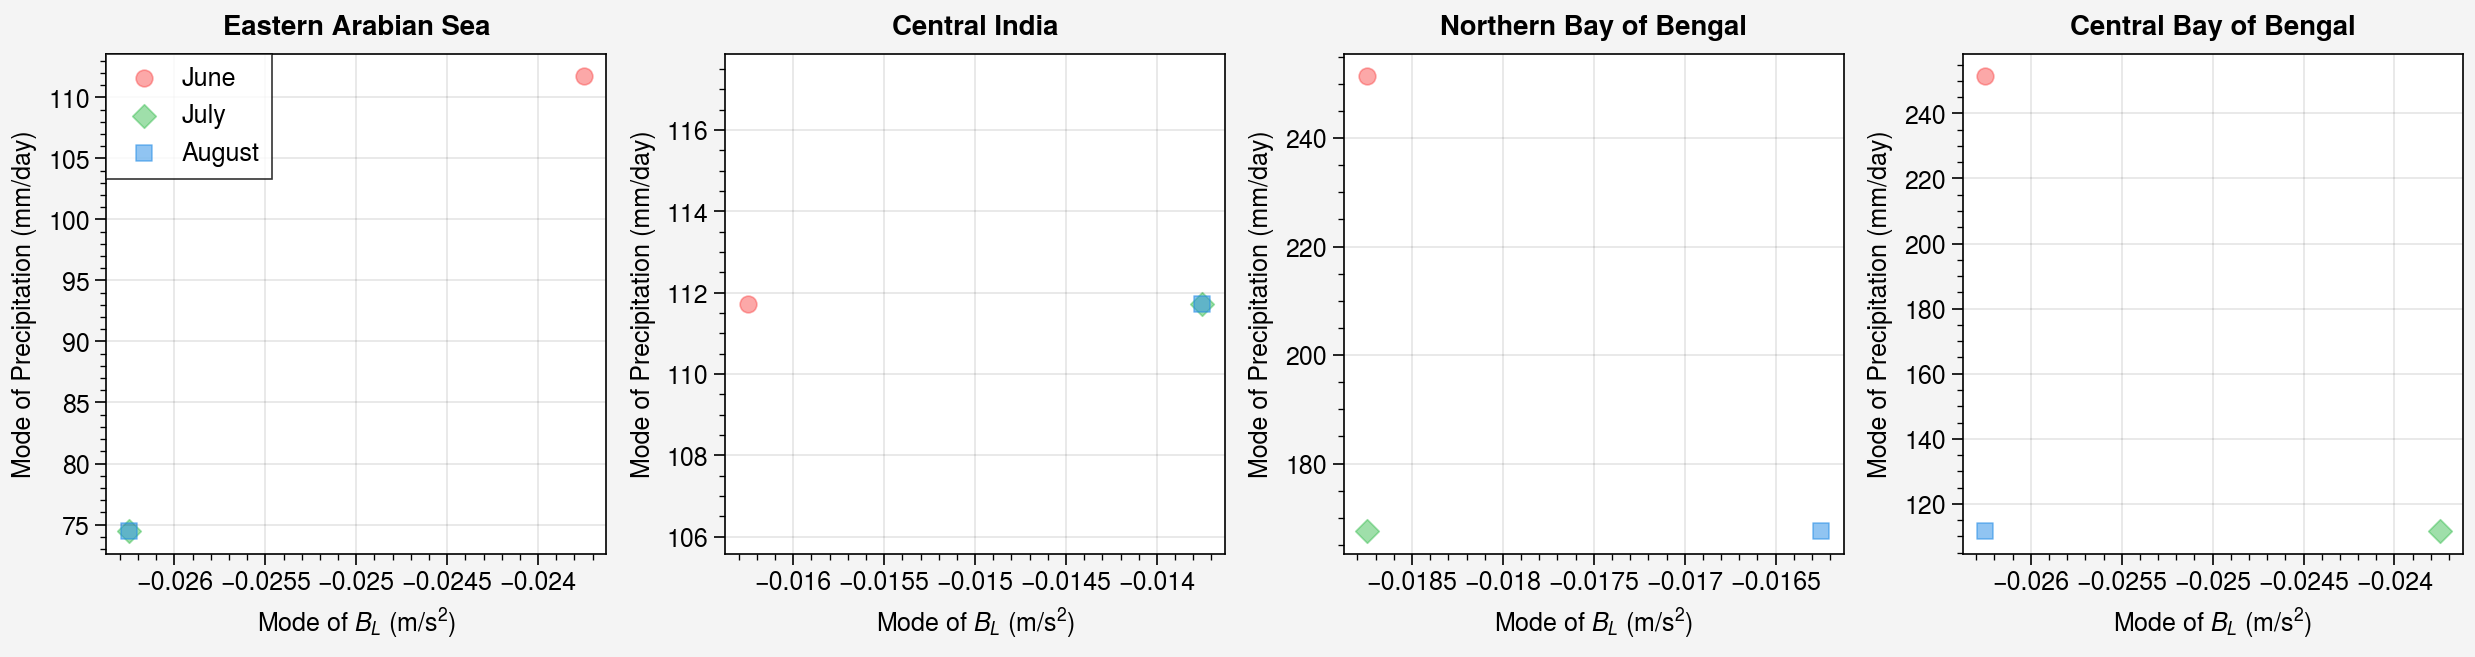

In [10]:
prbins = get_bin_edges(ds.pr,'pr')
blbins = get_bin_edges(ds.bl,'bl')

fig,axs = pplt.subplots(nrows=1,ncols=4,share=False,span=False)
axs.format(collabels=REGIONS.keys(),xlabel='Mode of $\mathit{B_L}$ (m/s$^2$)',ylabel='Mode of Precipitation (mm/day)')

for i,region in enumerate(REGIONS):
    regiondata = get_region(ds,region)
    for month,label,color,marker in CASES:
        monthdata = get_month(regiondata,month)
        blfreqdist = calc_freq_dist(monthdata.bl,blbins)
        pramtdist  = calc_amt_dist(monthdata.pr,prbins)
        blfreqmode = calc_mode(blfreqdist,blbins)
        pramtmode  = calc_mode(pramtdist,prbins)
        axs[i].scatter(blfreqmode,pramtmode,color=color,marker=marker,alpha=0.5,label=label)
axs[0].legend(loc='ul',ncols=1)
pplt.show()